In [655]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [656]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

from tqdm.auto import tqdm
from datasets import Dataset

import warnings
warnings.filterwarnings('ignore')

In [657]:
#importing training and test data
df_train  = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [658]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [659]:
print(f"Shape of train_df : {df_train.shape}")
print(f"Shape of test_df : {df_test.shape}")

Shape of train_df : (7613, 5)
Shape of test_df : (3263, 4)


In [660]:
train_records = df_train.to_dict(orient = "records")

In [661]:
random.sample(train_records, k=3)

[{'id': 8009,
  'keyword': 'refugees',
  'location': nan,
  'text': 'This just-married Turkish couple gave 4000 Syrian refugees an incredible gift http://t.co/ibeD3xG7fy Fed them instead of family &amp; friends.',
  'target': 1},
 {'id': 10018,
  'keyword': 'twister',
  'location': nan,
  'text': 'Twister was fun https://t.co/qCT6fb8wOn',
  'target': 0},
 {'id': 7833,
  'keyword': 'quarantine',
  'location': 'New York, United States',
  'text': 'Reddit Will Now Quarantine Offensive Content http://t.co/NAS3IPm5vh',
  'target': 0}]

In [662]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

def text_formatter(text : str):
    cleaned_text = " ".join(text.split())    
    cleaned_text = cleaned_text.lower()
    # Remove URLs
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    cleaned_text = re.sub(r'\d+','',cleaned_text)
    # Remove punctuation
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    return cleaned_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [663]:
sentence = '''Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the... http://t.co/FPrt7NwrOt
December 2011 court dismissed the group charge of rape victims saying 'getting raped was an occupational hazard..!'\n\nUS military = ISIS!
UPDATE: 7 of the 9 Mac Pros my company bought in May have had catastrophe failures requiring repair!'''
text_formatter(sentence)

'investigators say a fatal virgin galactic spaceship crash last year was caused by structural failure after the  december  court dismissed the group charge of rape victims saying getting raped was an occupational hazard us military  isis update  of the  mac pros my company bought in may have had catastrophe failures requiring repair'

In [664]:
df_train["processed_tweet"] = df_train["text"].apply(text_formatter)
df_test["processed_tweet"] = df_test["text"].apply(text_formatter)
df_train

,id,keyword,location,text,target,processed_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest the out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


In [665]:
df_train[df_train["target"] == 1]

,id,keyword,location,text,target,processed_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest the out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


In [666]:
df_train[df_train["target"] == 0]

,id,keyword,location,text,target,processed_tweet
15,23,NaN,NaN,What's up man?,0,whats up man
16,24,NaN,NaN,I love fruits,0,i love fruits
17,25,NaN,NaN,Summer is lovely,0,summer is lovely
18,26,NaN,NaN,My car is so fast,0,my car is so fast
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,what a goooooooaaaaaal
...,...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,engineshed great atmosphere at the british lio...
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0,cramer igers words that wrecked disneys stock...
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0,these boxes are ready to explode exploding kit...
7587,10841,NaN,NaN,Sirens everywhere!,0,sirens everywhere


# Creating train vallidation split

In [667]:
from sklearn.model_selection import train_test_split
X = df_train[["processed_tweet","target"]]
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [668]:
print(f"number of training records : {len(X_train)}")
print(f"number of validation records : {len(X_val)}")

number of training records : 6090
number of validation records : 1523


# Convert pandas dataframe to hugginface dataset format

In [669]:
hg_train = Dataset.from_pandas(X_train)
hg_test = Dataset.from_pandas(X_val)
hg_train, hg_test

(Dataset({
     features: ['processed_tweet', 'target', '__index_level_0__'],
     num_rows: 6090
 }),
 Dataset({
     features: ['processed_tweet', 'target', '__index_level_0__'],
     num_rows: 1523
 }))

In [670]:
hg_train[0]

{'processed_tweet': 'courageous and honest analysis of need to use atomic bomb in  hiroshima japanese military refused surrender ',
 'target': 1,
 '__index_level_0__': 4996}

In [671]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [672]:
def tokenize_dataset(data):
    return tokenizer(
        data["processed_tweet"],
        max_length=32,
        truncation= True,
        padding="max_length"
    )

train_dataset = hg_train.map(tokenize_dataset)
val_dataset = hg_test.map(tokenize_dataset)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [673]:
train_dataset = train_dataset.remove_columns(["processed_tweet","__index_level_0__"])
val_dataset = val_dataset.remove_columns(["processed_tweet","__index_level_0__"])

train_dataset = train_dataset.rename_column("target", "labels")
val_dataset = val_dataset.rename_column("target", "labels")
train_dataset.set_format("torch")
val_dataset.set_format("torch")

In [674]:
train_dataset, val_dataset

(Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 6090
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1523
 }))

In [675]:
#preparinf dataloaders for training and testing
BATCH_SIZE = 4
train_dataloader = DataLoader(dataset=train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
test_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False)

In [676]:
next(iter(train_dataloader))

{'labels': tensor([1, 1, 0, 0]),
 'input_ids': tensor([[  101,  7752, 11484,  2006,  2225,  2217, 15011,  3765,  3081,  2057,
           9333,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,  8519,  1999,  2605,  4088, 12843, 13297, 11385,  2179,  2006,
          10301,  2479,  2413,  2250,  4926,  8519,  2006,  9317,  2211, 12843,
           1056,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,  2275,  1037,  2047,  2501,  2163,  1999,  2420,  1045,  2123,
           2102,  2130,  2113,  2073,  1045,  2572,  2043,  1045,  5256,  2039,
           4902,  2054,  1037,  1059, 11961,  2140, 11101,  8295,  2296,  3371,
           2295,   102],
         [  101, 27829, 13716,  2618,  6137,  6761, 14969,  2098,  3900, 22123,
           8239,  7491,   102,     0,     0,     0,     0,     0,     0,     0,

In [677]:
#initializing loss function and optmizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [678]:
model = model.to(device)
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,  
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        
        batch = {k:v.to(device) for k,v in batch.items()}
        labels = batch["labels"]

        # Forward pass
        logits = model(**batch)
        y_pred = logits.logits
        
        #Calculate the loss
        loss = logits.loss
        train_loss  += loss.item()
        
        #zero grad the optmizer
        optimizer.zero_grad()
        
        #backpropogating loass
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim=1)
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [679]:
def test_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader):
    model.eval()
    
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch in dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            labels = batch["labels"]

            # Forward pass
            logits = model(**batch)
            y_pred = logits.logits
            loss = logits.loss
            test_loss += loss.item()
            
            test_pred_label = torch.argmax(torch.softmax(y_pred, dim =1), dim=1)
            test_acc += (test_pred_label == labels).sum().item()/len(y_pred)
        
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

In [680]:
from tqdm.auto import tqdm
from torch import nn

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [681]:
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer, 
                        epochs=EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4716 | train_acc: 0.7928 | test_loss: 0.4143 | test_acc: 0.8344
Epoch: 2 | train_loss: 0.3507 | train_acc: 0.8662 | test_loss: 0.4416 | test_acc: 0.8147
Epoch: 3 | train_loss: 0.2530 | train_acc: 0.9100 | test_loss: 0.4971 | test_acc: 0.8206
Epoch: 4 | train_loss: 0.1737 | train_acc: 0.9391 | test_loss: 0.6550 | test_acc: 0.8200
Epoch: 5 | train_loss: 0.1179 | train_acc: 0.9567 | test_loss: 0.5942 | test_acc: 0.8154


In [682]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

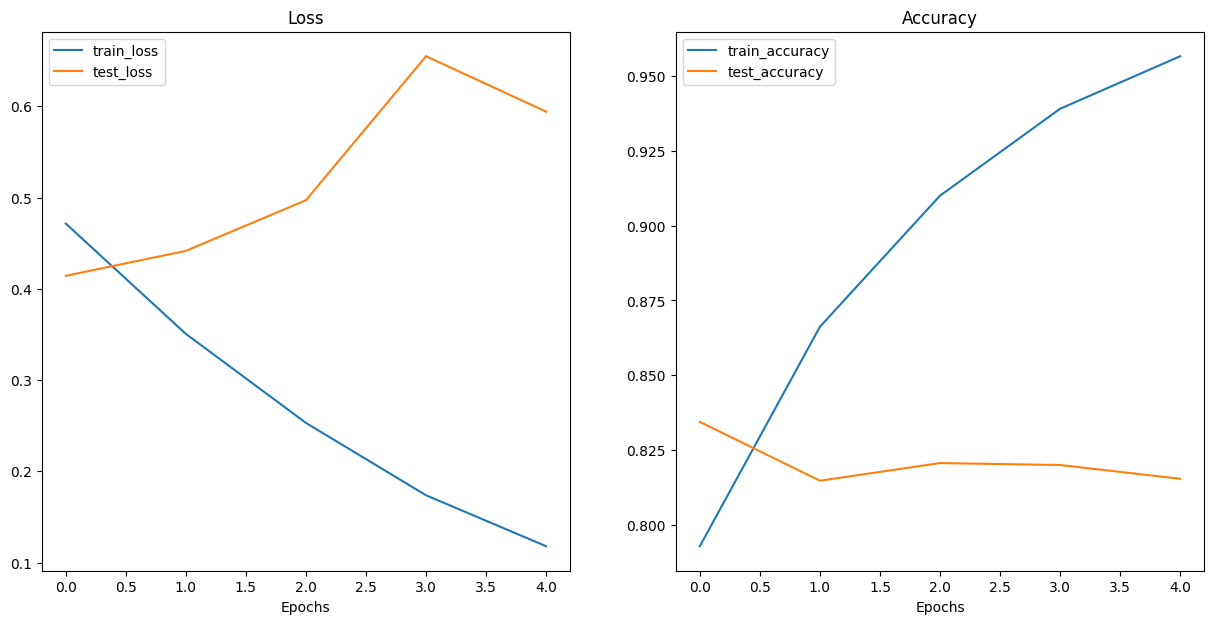

In [683]:
plot_loss_curves(model_results)

# Confusion Matrix

In [684]:
y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for batch in test_dataloader:
        batch = {k:v.to(device) for k,v in batch.items()}
        target_labels = batch["labels"]
        
        y_pred = model(**batch).logits
        
        
        test_pred = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        y_preds.append(test_pred.cpu())
        y_true.append(target_labels.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

In [685]:
y_pred_tensor

tensor([0, 0, 0,  ..., 1, 1, 1])

In [686]:
class_names = df_train['target'].unique().tolist()
class_names

[1, 0]

In [687]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


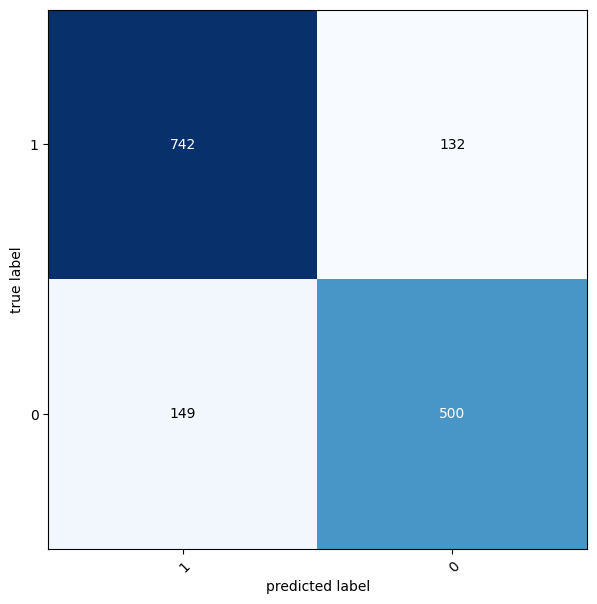

In [688]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='Binary')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [689]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [690]:
df_test["processed_tweet"] = df_test["text"].apply(text_formatter)

In [691]:
id = df_test["id"]
test = df_test[["processed_tweet"]]

In [692]:
def prediction(df):
    BATCH_SIZE = 4
    test_preds = []
    hg_test = Dataset.from_pandas(df)
    test_dataset = hg_test.map(tokenize_dataset)
    test_dataset = test_dataset.remove_columns(["processed_tweet"])
    test_dataset.set_format("torch")
   
    test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)
    model.eval()
    with torch.inference_mode():
        for batch in test_dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            
            y_pred = model(**batch).logits


            test_pred = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
            test_preds.append(test_pred.cpu())

    y_pred_tensor = torch.cat(test_preds)
    return y_pred_tensor

In [693]:
target = prediction(test)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [694]:
len(target)

3263

In [695]:
submission = pd.DataFrame({"id":id,
                           "target": target})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [697]:
submission.to_csv('submission.csv', index=False)